In [1]:
import gzip
import os
import pickle
import time
import torch
import sys
import json
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
from collections import defaultdict
from tqdm import tqdm

sys.path.append('./')
sys.path.append('./sw/')

from experiments import utils
from IVIMNET.hyperparams import hyperparams as hp_example_1
import IVIMNET.simulations as sim
import IVIMNET.deep as deep
import IVIMNET.deep_bayes as deep_bayes
import IVIMNET.fitting_algorithms as fit

In [2]:
BNN_PATH_INVIVO = './sw/models/bnn_e08_patient.pt'
BNN_PATH_SYNTH = "./sw/models/bnn_e17.pt"
BNN_PATH_BOTH = "./sw/models/bnn_e18.pt"
BVAL_PATH = "./sw/data/example_data/bvalues.bval"

SIGNAL_PATH = "./sw/data/example_data/data.nii.gz"
params = defaultdict(dict)

In [3]:
data = nib.load(SIGNAL_PATH)
datas = data.get_fdata()
sx, sy, sz, n_b_values = datas.shape 


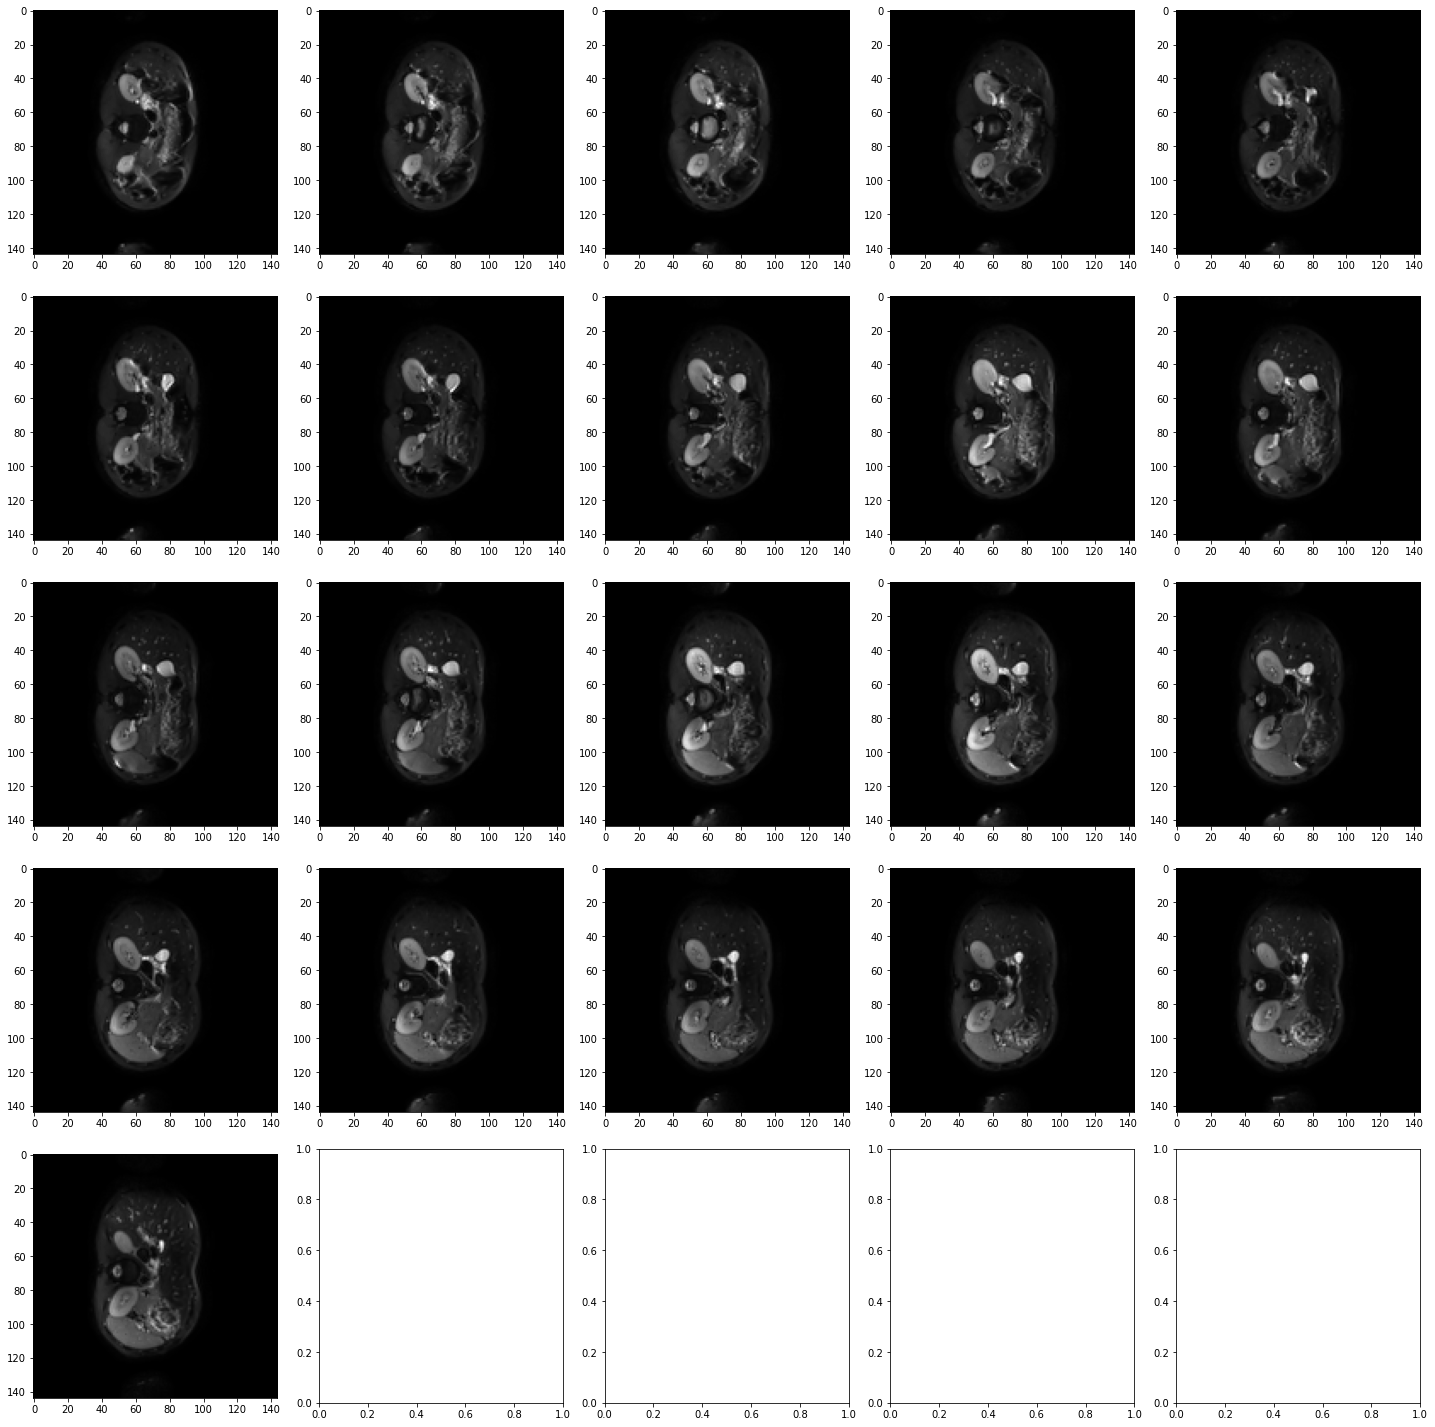

In [4]:
fig, ax = plt.subplots(5, 5, figsize=(20,20))
for i in range(sz):
    ax[i//5, i%5].imshow(datas[:,:,i,0], cmap="gray")
plt.tight_layout()
plt.show()

In [5]:
# input_z_slice_idx = 7
# datas = datas[:,:,input_z_slice_idx,:]
# sz = 1
X_dw = np.reshape(datas, (sx * sy * sz, n_b_values))

In [6]:
# Load bvalues
bvalues = np.genfromtxt(BVAL_PATH)
selsb = bvalues == 0

# Delete background and noise
S0 = np.nanmean(X_dw[:, selsb], axis=1)
S0[S0 != S0] = 0
S0 = np.squeeze(S0)
valid_id = (S0 > (0.5 * np.median(S0[S0 > 0]))) 
datatot = X_dw[valid_id, :]
# Normalise data
S0 = np.nanmean(datatot[:, selsb], axis=1).astype('<f')
datatot = datatot / S0[:, None]

In [7]:
arg = hp_example_1()
arg = deep.checkarg(arg)
def update_params(data, path, key, device = "cuda"):
    net = torch.load(path, map_location=device)
    
    ## normalise the signal to b=0 and remove data with nans
    data = deep.normalise(data, bvalues, arg)
    mylist = np.isnan(np.mean(data, axis=1))
    sels = [not i for i in mylist]
    # remove data with non-IVIM-like behaviour. Estimating IVIM parameters in these data is meaningless anyways.
    sels = sels & (np.percentile(data[:, bvalues < 50], 0.95, axis=1) < 1.3) & (
                np.percentile(data[:, bvalues > 50], 0.95, axis=1) < 1.2) & (
                       np.percentile(data[:, bvalues > 150], 0.95, axis=1) < 1.0)
    # we need this for later
    lend = len(data)
    data = data[sels]
    
    # initialise dataloader. Batch size can be way larger as we are still training.
    inferloader = torch.utils.data.DataLoader(torch.from_numpy(data.astype(np.float32)),
                                   batch_size=1024,
                                   shuffle=False,
                                   drop_last=False)
    
    # initialise parameters and data
    X  = []
    Dp = []
    Dt = []
    Fp = []
    S0 = []
    
    # start predicting
    with torch.no_grad():
        for i, X_batch in tqdm(enumerate(inferloader, 0)):
            X_batch = X_batch.to(device)
            # here the signal is predicted. Note that we now are interested in the parameters and no longer in the predicted signal decay.
            Xt, Dtt, Fpt, Dpt, S0t = net(X_batch)
            X.append(Xt.cpu().numpy())
            S0.append(S0t.cpu().numpy())
            Dt.append(Dtt.cpu().numpy())
            Fp.append(Fpt.cpu().numpy())
            Dp.append(Dpt.cpu().numpy())
            del Xt; del Dtt; del Fpt; del Dpt; del S0t

    X = np.concatenate(X, axis=1)
    Dp = np.concatenate(Dp, axis=1)
    Dt = np.concatenate(Dt, axis=1)
    Fp = np.concatenate(Fp, axis=1)
    S0 = np.concatenate(S0, axis=1)
    
    if np.mean(Dp) < np.mean(Dt):
        Dp22 = copy.deepcopy(Dt)
        Dt = copy.deepcopy(Dp)
        Dp = copy.deepcopy(Dp22)
        Fp = 1 - Fp    # here we correct for the data that initially was removed as it did not have IVIM behaviour, by returning zero

    # estimates
    Xtrue = np.asarray(X)
    Dptrue = np.zeros((net.bayes_samples, lend))
    Dttrue = np.zeros((net.bayes_samples, lend))
    Fptrue = np.zeros((net.bayes_samples, lend))
    S0true = np.zeros((net.bayes_samples, lend))
    Dptrue[:, sels] = Dp.reshape(net.bayes_samples, -1)
    Dttrue[:, sels] = Dt.reshape(net.bayes_samples, -1)
    Fptrue[:, sels] = Fp.reshape(net.bayes_samples, -1)
    S0true[:, sels] = S0.reshape(net.bayes_samples, -1)
    
    torch.cuda.empty_cache()
    
    return X, Dp, Dt, Fp, sels

C:\Users\user\OneDrive - Imperial College London\Imperial\Courses\2021\_FYP\code\IVIM-BNNET\./sw\IVIMNET\deep.py:882: UserWarning: arg no norm_data_full. Using default of False
  warnings.warn('arg no norm_data_full. Using default of False')
C:\Users\user\OneDrive - Imperial College London\Imperial\Courses\2021\_FYP\code\IVIM-BNNET\./sw\IVIMNET\deep.py:789: UserWarning: arg.train.plateau_size not defined. Using default of 20
  warnings.warn('arg.train.plateau_size not defined. Using default of 20')


In [8]:
datatot.shape

(110589, 104)

In [9]:
%time x_v, dp_v, dt_v, fp_v, sels_v = update_params(datatot, BNN_PATH_INVIVO, "v")

108it [00:08, 13.07it/s]


Wall time: 9.94 s


In [10]:
%time x_s, dp_s, dt_s, fp_s, sels_s = update_params(datatot, BNN_PATH_INVIVO, "s")

108it [00:04, 24.94it/s]


Wall time: 6.28 s


In [11]:
%time x_b, dp_b, dt_b, fp_b, sels_b = update_params(datatot, BNN_PATH_INVIVO, "b")

108it [00:04, 24.35it/s]


Wall time: 13.1 s


(20736,)
(64, 5189, 1)


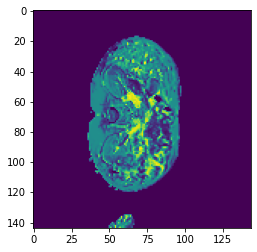

In [88]:
img = np.zeros((sx * sy * sz))
print(img.shape)
print(dp.shape)
img[valid_id] = np.mean(dp, axis=0).reshape(-1)
plt.imshow(img.reshape((sx, sy, sz))[:,:,0])

20736